In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split, Dataset, SubsetRandomSampler
from collections import Counter
import os
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score

In [2]:
# Define paths to downloaded files

train_images_path = "data/KMNIST/raw/k49-train-imgs.npz"
train_labels_path = "data/KMNIST/raw/k49-train-labels.npz"
test_images_path = "data/KMNIST/raw/k49-test-imgs.npz"
test_labels_path = "data/KMNIST/raw/k49-test-labels.npz"

# Load the dataset
train_images = np.load(train_images_path)['arr_0']
train_labels = np.load(train_labels_path)['arr_0']
test_images = np.load(test_images_path)['arr_0']
test_labels = np.load(test_labels_path)['arr_0']

print(f"Train Images Shape: {train_images.shape}")  # (270912, 28, 28)
print(f"Train Labels Shape: {train_labels.shape}")  # (270912,)
print(f"Test Images Shape: {test_images.shape}")    # (45792, 28, 28)
print(f"Test Labels Shape: {test_labels.shape}")    # (45792,)

Train Images Shape: (232365, 28, 28)
Train Labels Shape: (232365,)
Test Images Shape: (38547, 28, 28)
Test Labels Shape: (38547,)


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Custom dataset class
class Kuzushiji49Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL image and apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Create dataset instances
train_set = Kuzushiji49Dataset(train_images, train_labels, transform=transform)
test_set = Kuzushiji49Dataset(test_images, test_labels, transform=transform)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print(f"Total training samples: {len(train_set)}")
print(f"Total testing samples: {len(test_set)}")

Total training samples: 232365
Total testing samples: 38547


# Random Prototyping

In [4]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Extract entire train and test data
train_data = torch.cat([data for data, _ in train_loader], dim=0)
train_labels = torch.cat([labels for _, labels in train_loader], dim=0)

test_data = torch.cat([data for data, _ in test_loader], dim=0)
test_labels = torch.cat([labels for _, labels in test_loader], dim=0)

# Flatten images from (N, 1, 28, 28) -> (N, 784)
train_data = train_data.view(train_data.shape[0], -1).to(device)  # (60000, 784)
test_data = test_data.view(test_data.shape[0], -1).to(device)  # (10000, 784)

train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

Using device: cpu


In [7]:
mapping_path = 'data/KMNIST/raw/k49_classmap.csv'
mapping = pd.read_csv(mapping_path)
mapping

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お
5,5,U+304B,か
6,6,U+304D,き
7,7,U+304F,く
8,8,U+3051,け
9,9,U+3053,こ


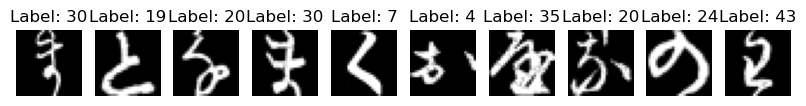

In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot first 5 images
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(0,10):
    axes[i].imshow(train_images[i].squeeze(), cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Label: {train_labels[i].item()}")

plt.show()

In [5]:
num_subsets = np.array([125000, 75000, 50000, 10000])

In [6]:
def compute_accuracy(test_data, prototype_data, prototype_labels, k=1):
    # Compute full pairwise distance matrix in one go
    print("Computing full distance matrix...")
    distances = torch.cdist(test_data, prototype_data)  # Shape: (10000, 60000)

    # Get indices of k nearest neighbors
    k_indices = torch.topk(distances, k, largest=False).indices  # Shape: (10000, k)

    # Retrieve the k nearest labels
    k_labels = prototype_labels[k_indices]  # Shape: (10000, k)

    # Majority voting for prediction
    pred_labels = torch.mode(k_labels, dim=1).values  # Shape: (10000,)

    # Compute accuracy
    accuracy = (pred_labels == test_labels).float().mean().item()
    print(f'{k}-NN accuracy on full test set (no batching): {accuracy:.4f}')
    return accuracy

In [11]:
accuracy_dict = {}
for subset in num_subsets:
    accuracy_list = []
    for _ in range(10):
        random_indicies = torch.randperm(train_data.shape[0])[:subset]
        prototype_train_data = train_data[random_indicies]
        prototype_train_labels = train_labels[random_indicies]
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
        accuracy_list.append(accuracy)
    accuracy_dict[subset] = accuracy_list

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8306
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8298
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8294
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8291
Computing full distance matrix...


KeyboardInterrupt: 

In [ ]:
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df.mean(), accuracy_df.std(ddof=1)

(125000    0.829268
 75000     0.804447
 50000     0.782390
 10000     0.666864
 dtype: float64,
 125000    0.000761
 75000     0.001689
 50000     0.001913
 10000     0.003843
 dtype: float64)

### Varying K

In [8]:
full_accuracy_df_random = pd.DataFrame()

num_neighbors = np.arange(1,31,2)

for k in num_neighbors:
    accuracy_dict_random_per_neigbor = {}
    for subset in num_subsets:
        accuracy_list = []
        for _ in range(5):
            random_indicies = torch.randperm(train_data.shape[0])[:subset]
            prototype_train_data = train_data[random_indicies]
            prototype_train_labels = train_labels[random_indicies]
            accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
            accuracy_list.append(accuracy)
        accuracy_dict_random_per_neigbor[subset] = accuracy_list
    temp = pd.DataFrame(accuracy_dict_random_per_neigbor)
    temp['k'] = k
    full_accuracy_df_random = pd.concat([full_accuracy_df_random, temp], axis=0)

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8315
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8296
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8246
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8284
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8299
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8058
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8041
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8043
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8030
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8060
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7788
Computing full distance matrix...
1-NN accu

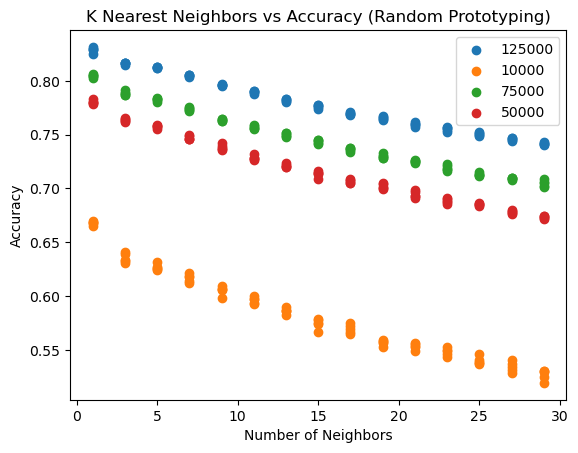

In [11]:
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[125000], label='125000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[10000], label='10000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[75000], label='75000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[50000], label='50000')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (Random Prototyping)')
plt.legend()
plt.show()

# K Means

## K Means

### Base Functions

In [92]:
# Perform K-Means clustering

def optimized_kmeans(X, k, num_iters=100, tol=1e-4, batch_size=5000, device='cpu'):
    X = X.to(device, dtype=torch.float32)  # Ensure correct dtype
    N, D = X.shape

    # Initialize centroids randomly
    indices = torch.randperm(N)[:k]
    centroids = X[indices]

    for i in range(num_iters):
        cluster_assignments = torch.empty(N, dtype=torch.long, device=device)

        # Compute distances in batches to save memory
        for j in range(0, N, batch_size):
            batch = X[j:j+batch_size]
            distances = torch.cdist(batch, centroids)  # Compute distance for this batch
            cluster_assignments[j:j+batch_size] = torch.argmin(distances, dim=1)  # Assign cluster

        # Compute new centroids
        new_centroids = torch.zeros_like(centroids)
        counts = torch.zeros(k, device=device)

        for c in range(k):
            cluster_indices = (cluster_assignments == c).nonzero(as_tuple=True)[0]
            if cluster_indices.numel() > 0:
                new_centroids[c] = X[cluster_indices].mean(dim=0)
                counts[c] = cluster_indices.numel()
            else:
                # Assign the farthest point to avoid empty clusters
                farthest_point = X[torch.argmax(torch.cdist(X, centroids[c].unsqueeze(0)), dim=0)]
                new_centroids[c] = farthest_point

        # Check for convergence
        if torch.allclose(new_centroids, centroids, atol=tol):
            print(f'Converged at iteration {i}')
            break

        centroids = new_centroids

    return cluster_assignments, centroids




# Function to assign labels to centroids
def assign_labels(cluster_labels, y_true, k):
    """
    Assigns a label to each K-Means cluster using majority voting.
    
    Args:
    - cluster_labels (Tensor): Cluster assignments for each point
    - y_true (Tensor): True MNIST labels
    - k (int): Number of clusters

    Returns:
    - cluster_to_label (list): List where index `i` corresponds to cluster `i`'s assigned label
    """
    cluster_to_label = [-1] * k  # Initialize list with -1 for empty clusters

    for cluster in range(k):
        # Get all true labels for this cluster
        cluster_indices = (cluster_labels == cluster).nonzero(as_tuple=True)[0]
        true_labels = y_true[cluster_indices]

        # Find the most common label in this cluster
        if len(true_labels) > 0:
            most_common_label = Counter(true_labels.tolist()).most_common(1)[0][0]
            cluster_to_label[cluster] = most_common_label

    return cluster_to_label


### Centroids

In [93]:
for subset in num_subsets:
    if os.path.exists(f"kmnist_centroids/kmnist_kmeans_centroids_{subset}.pth"):
        continue
    else:
        cluster_labels, centroids = optimized_kmeans(train_data, subset)
        cluster_to_label = assign_labels(cluster_labels, train_labels, subset)
        if os.path.exists('kmnist_centroids') == False:
            os.mkdir('kmnist_centroids')
        torch.save(centroids, f"kmnist_centroids/kmnist_kmeans_centroids_{subset}.pth")
        torch.save(cluster_to_label, f"kmnist_centroids/kmnist_kmeans_cluster_labels_{subset}.pth")

Converged at iteration 6
Converged at iteration 9
Converged at iteration 14
Converged at iteration 30


### Make Predictions

In [94]:
accuracy_dict_kmeans = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"kmnist_centroids/kmnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"kmnist_centroids/kmnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
    accuracy_dict_kmeans[subset] = [accuracy]

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8392
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8298
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8226
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7893


In [95]:
accuracy_df_kmeans = pd.DataFrame(accuracy_dict_kmeans)
accuracy_df_kmeans

,125000,75000,50000,10000
0,0.839209,0.829844,0.82258,0.78927


### Varying size K

In [96]:
full_accuracy_df_kmeans = pd.DataFrame()

num_neighbors = np.arange(1,30,2)

for k in num_neighbors:
    accuracy_dict_kmean_per_neigbor = {}
    for subset in num_subsets:
        prototype_train_data = torch.load(f"kmnist_centroids/kmnist_kmeans_centroids_{subset}.pth", weights_only=False)
        prototype_train_labels = torch.tensor(torch.load(f"kmnist_centroids/kmnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
        accuracy_dict_kmean_per_neigbor[subset] = [accuracy]
    temp = pd.DataFrame(accuracy_dict_kmean_per_neigbor)
    full_accuracy_df_kmeans = pd.concat([full_accuracy_df_kmeans, temp], axis=0)
full_accuracy_df_kmeans['k'] = num_neighbors

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8392
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8298
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8226
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7893
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8314
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8228
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8119
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.7637
Computing full distance matrix...
5-NN accuracy on full test set (no batching): 0.8322
Computing full distance matrix...
5-NN accuracy on full test set (no batching): 0.8188
Computing full distance matrix...
5-NN accuracy on full test set (no batching): 0.8104
Computing full distance matrix...
5-NN accu

In [97]:
full_accuracy_df_kmeans

,125000,75000,50000,10000,k
0,0.839209,0.829844,0.822580,0.789270,1
0,0.831401,0.822788,0.811866,0.763743,3
0,0.832205,0.818819,0.810413,0.758139,5
0,0.826264,0.811736,0.802916,0.745843,7
0,0.820012,0.805666,0.796275,0.735621,9
0,0.815576,0.800841,0.789192,0.724440,11
0,0.809350,0.794121,0.782058,0.716035,13
0,0.803279,0.789063,0.775287,0.707967,15
0,0.798843,0.783952,0.769243,0.699302,17
0,0.792072,0.779205,0.764002,0.691364,19


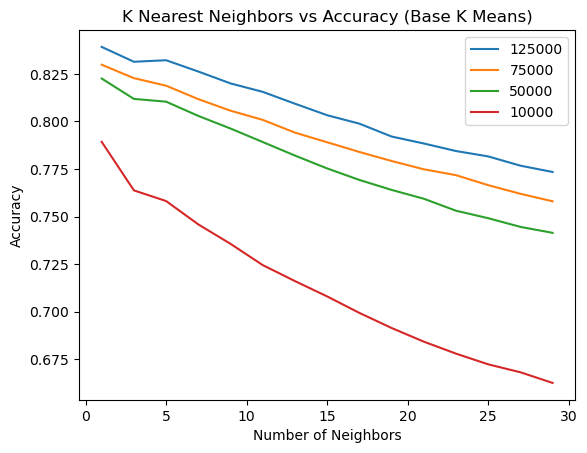

In [98]:
for subset in num_subsets:
    plt.plot(full_accuracy_df_kmeans['k'], full_accuracy_df_kmeans[subset], label=f'{subset}')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (Base K Means)')
plt.legend()
plt.show()

# Learning Models

## Full Data

### Base Logit

In [156]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)  # Fully connected layer
        self.init_weights()
    
    def forward(self, x):
        return self.linear(x)  # No activation, since CrossEntropyLoss applies softmax
    
    def init_weights(self):
        nn.init.zeros_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

In [157]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=8, pin_memory=True)

In [158]:
input_dim = 28 * 28
num_classes = 49
logit_model = LogisticRegression(input_dim, num_classes)

In [159]:
criterion = nn.CrossEntropyLoss()
optimizer_sdg = optim.SGD(logit_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

In [160]:
num_epochs = 100
tolerance = 1e-4  # Minimum improvement in loss to continue training
patience = 3
previous_loss = float('inf')  # Track the best loss
epochs_without_improvement = 0  # Counter for early stopping

loss_list_logit = []
for epoch in range(num_epochs):
    logit_model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

        # Forward pass
        outputs = logit_model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer_sdg.zero_grad(set_to_none=True)
        loss.backward()
        optimizer_sdg.step()

        total_loss += loss.item()  # Accumulate total loss

    current_loss = total_loss / len(train_loader)  # Compute average loss
    loss_list_logit.append(current_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

    # Check for early stopping
    if previous_loss - current_loss < tolerance:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
            break
    else:
        epochs_without_improvement = 0  # Reset counter if improvement occurs
    previous_loss = current_loss

Epoch [1/100], Loss: 1.5014
Epoch [2/100], Loss: 1.2947
Epoch [3/100], Loss: 1.2648
Epoch [4/100], Loss: 1.2498
Epoch [5/100], Loss: 1.2403
Epoch [6/100], Loss: 1.2325
Epoch [7/100], Loss: 1.2274
Epoch [8/100], Loss: 1.2237
Epoch [9/100], Loss: 1.2195
Epoch [10/100], Loss: 1.2168
Epoch [11/100], Loss: 1.2134
Epoch [12/100], Loss: 1.2112
Epoch [13/100], Loss: 1.2092
Epoch [14/100], Loss: 1.2070
Epoch [15/100], Loss: 1.2065
Epoch [16/100], Loss: 1.2045
Epoch [17/100], Loss: 1.2028
Epoch [18/100], Loss: 1.2019
Epoch [19/100], Loss: 1.2012
Epoch [20/100], Loss: 1.2012
Epoch [21/100], Loss: 1.1982
Epoch [22/100], Loss: 1.1980
Epoch [23/100], Loss: 1.1967
Epoch [24/100], Loss: 1.1967
Epoch [25/100], Loss: 1.1953
Epoch [26/100], Loss: 1.1949
Epoch [27/100], Loss: 1.1934
Epoch [28/100], Loss: 1.1937
Epoch [29/100], Loss: 1.1920
Epoch [30/100], Loss: 1.1922
Epoch [31/100], Loss: 1.1922
Epoch [32/100], Loss: 1.1923
Stopping early at epoch 32 (Loss improvement < 0.0001 for 3 epochs)


In [161]:
logit_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = logit_model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy Base Logit: {accuracy:.2f}%")

Test Accuracy Base Logit: 57.02%


### Lipschitz Logit

In [162]:
# Define Adam Optimizer
logit_model_lipschitz = LogisticRegression(input_dim, num_classes)
optimizer_sdg = optim.SGD(logit_model_lipschitz.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


# Early stopping parameters
tolerance = 1e-4  # Minimum change in loss to continue training
patience = 3  # Number of epochs to wait for improvement
previous_loss = float('inf')
epochs_without_improvement = 0  # Counter for early stopping

# Training loop with early stopping
num_epochs = 100  # Maximum epochs
loss_list_logit_lip = []
for epoch in range(num_epochs):
    logit_model_lipschitz.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 28 * 28)  # Flatten images

        outputs = logit_model_lipschitz(images)
        loss = criterion(outputs, labels)

        logit_model_lipschitz.zero_grad()
        loss.backward()

        L = max(param.grad.abs().max().item() for param in logit_model_lipschitz.parameters() if param.grad is not None)
        adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

        # Update optimizer's learning rate
        for param_group in optimizer_sdg.param_groups:
            param_group['lr'] = adaptive_lr

        optimizer_sdg.step()

        total_loss += loss.item()

    current_loss = total_loss / len(train_loader)
    loss_list_logit_lip.append(current_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

    # Check for early stopping
    if previous_loss - current_loss < tolerance:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
            break
    else:
        epochs_without_improvement = 0  # Reset counter if improvement occurs
    previous_loss = current_loss


Epoch [1/100], Loss: 1.5010
Epoch [2/100], Loss: 1.2955
Epoch [3/100], Loss: 1.2642
Epoch [4/100], Loss: 1.2485
Epoch [5/100], Loss: 1.2410
Epoch [6/100], Loss: 1.2330
Epoch [7/100], Loss: 1.2266
Epoch [8/100], Loss: 1.2242
Epoch [9/100], Loss: 1.2191
Epoch [10/100], Loss: 1.2158
Epoch [11/100], Loss: 1.2132
Epoch [12/100], Loss: 1.2110
Epoch [13/100], Loss: 1.2101
Epoch [14/100], Loss: 1.2075
Epoch [15/100], Loss: 1.2063
Epoch [16/100], Loss: 1.2044
Epoch [17/100], Loss: 1.2031
Epoch [18/100], Loss: 1.2022
Epoch [19/100], Loss: 1.2013
Epoch [20/100], Loss: 1.1988
Epoch [21/100], Loss: 1.1996
Epoch [22/100], Loss: 1.1987
Epoch [23/100], Loss: 1.1983
Epoch [24/100], Loss: 1.1963
Epoch [25/100], Loss: 1.1960
Epoch [26/100], Loss: 1.1945
Epoch [27/100], Loss: 1.1948
Epoch [28/100], Loss: 1.1934
Epoch [29/100], Loss: 1.1930
Epoch [30/100], Loss: 1.1923
Epoch [31/100], Loss: 1.1931
Epoch [32/100], Loss: 1.1916
Epoch [33/100], Loss: 1.1910
Epoch [34/100], Loss: 1.1895
Epoch [35/100], Loss: 1

In [163]:
logit_model_lipschitz.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 28*28)
        
        outputs = logit_model_lipschitz(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy())  # Collect true labels

balanced_acc = balanced_accuracy_score(all_labels, all_preds)
print(f"Balanced Accuracy Newtonian Logit: {balanced_acc:.4f}")

Balanced Accuracy Newtonian Logit: 0.5461


### Neural Network

In [164]:
class KMNIST_CNN(nn.Module):
    def __init__(self, num_classes):
        super(KMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # Corrected input size
        self.fc2 = nn.Linear(256, num_classes)  # Adjust output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)  # Dynamically flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [165]:
cnn_model = KMNIST_CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_sdg = optim.SGD(cnn_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

In [166]:
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set_small, val_set = random_split(train_set, [train_size, val_size])

In [167]:
train_loader_cnn = DataLoader(
    train_set_small, batch_size=256, shuffle=True, 
    num_workers=8, pin_memory=True
)
val_loader_cnn = DataLoader(
    val_set, batch_size=256, shuffle=False, 
    num_workers=8, pin_memory=True
)
test_loader_cnn = DataLoader(
    test_set, batch_size=256, shuffle=False, 
    num_workers=8, pin_memory=True
)

In [168]:
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0


# Training loop
num_epochs = 50
loss_list_cnn = []
for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0


    for images, labels in train_loader_cnn:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)


        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer_sdg.zero_grad(set_to_none=True)
        loss.backward()
        optimizer_sdg.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader_cnn)

    # Validation loop
    cnn_model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader_cnn:
            images, labels = images.to(device), labels.to(device)

            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()


    val_loss /= len(val_loader_cnn)
    loss_list_cnn.append(train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
            break

Epoch [1/50], Train Loss: 1.1611 Val Loss: 0.4539
Epoch [2/50], Train Loss: 0.3388 Val Loss: 0.2831
Epoch [3/50], Train Loss: 0.2280 Val Loss: 0.2317
Epoch [4/50], Train Loss: 0.1783 Val Loss: 0.2092
Epoch [5/50], Train Loss: 0.1468 Val Loss: 0.1903
Epoch [6/50], Train Loss: 0.1240 Val Loss: 0.1874
Epoch [7/50], Train Loss: 0.1055 Val Loss: 0.1773
Epoch [8/50], Train Loss: 0.0909 Val Loss: 0.1799
Epoch [9/50], Train Loss: 0.0787 Val Loss: 0.1757
Epoch [10/50], Train Loss: 0.0679 Val Loss: 0.1683
Epoch [11/50], Train Loss: 0.0579 Val Loss: 0.1778
Epoch [12/50], Train Loss: 0.0508 Val Loss: 0.1768
Epoch [13/50], Train Loss: 0.0436 Val Loss: 0.1819
Epoch [14/50], Train Loss: 0.0379 Val Loss: 0.1827
Epoch [15/50], Train Loss: 0.0325 Val Loss: 0.1905
Stopping early at epoch 15 (No improvement in 5 epochs)


In [169]:
cnn_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy())  # Collect true labels

balanced_acc = balanced_accuracy_score(all_labels, all_preds)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Balanced Accuracy: 0.9115


### Neural Network Lipschitz

In [170]:
cnn_model_lipschitz = KMNIST_CNN(num_classes).to(device)
optimizer_sdg = optim.SGD(cnn_model_lipschitz.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [171]:
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

# Training loop
num_epochs = 50
loss_list_cnn_lip = []
for epoch in range(num_epochs):
    cnn_model_lipschitz.train()
    total_loss = 0
    for images, labels in train_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_model_lipschitz(images)
        loss = criterion(outputs, labels)

    
        # Backward pass
        optimizer_sdg.zero_grad(set_to_none=True)
        loss.backward()

        L = max(param.grad.abs().max().item() for param in cnn_model_lipschitz.parameters() if param.grad is not None)
        adaptive_lr = min(0.1, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

        # Update optimizer's learning rate
        for param_group in optimizer_sdg.param_groups:
            param_group['lr'] = adaptive_lr

        optimizer_sdg.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader_cnn)

    # Validation loop
    cnn_model_lipschitz.eval()
    val_loss = 0
    
    with torch.no_grad():
        for images, labels in val_loader_cnn:
            images, labels = images.to(device), labels.to(device)

            outputs = cnn_model_lipschitz(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader_cnn)
    loss_list_cnn_lip.append(train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
            break

Epoch [1/50], Train Loss: 0.5578 Val Loss: 0.2258
Epoch [2/50], Train Loss: 0.1738 Val Loss: 0.1809
Epoch [3/50], Train Loss: 0.1181 Val Loss: 0.1806
Epoch [4/50], Train Loss: 0.0907 Val Loss: 0.1683
Epoch [5/50], Train Loss: 0.0697 Val Loss: 0.1687
Epoch [6/50], Train Loss: 0.0591 Val Loss: 0.1761
Epoch [7/50], Train Loss: 0.0497 Val Loss: 0.1801
Epoch [8/50], Train Loss: 0.0429 Val Loss: 0.1735
Epoch [9/50], Train Loss: 0.0406 Val Loss: 0.1883
Stopping early at epoch 9 (No improvement in 5 epochs)


In [172]:
cnn_model_lipschitz.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images, labels = images.to(device), labels.to(device)
        
        outputs = cnn_model_lipschitz(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy Newtonian Logit: {accuracy:.2f}%")

Test Accuracy Newtonian Logit: 92.05%


In [173]:
import matplotlib.pyplot as plt

In [184]:
loss_dict = {
    'cnn': loss_list_cnn,
    'cnn_lip': loss_list_cnn_lip
}

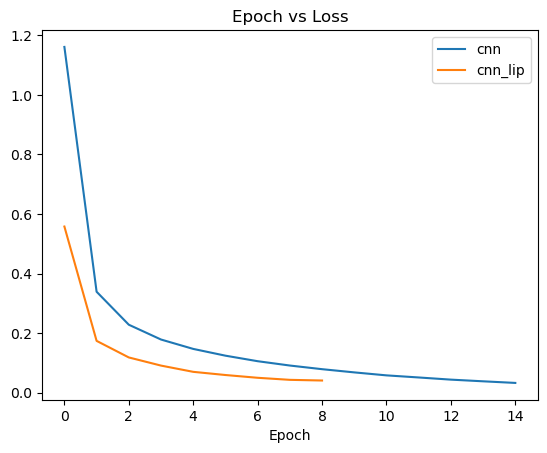

In [188]:
for model in loss_dict:
    plt.plot(np.arange(len(loss_dict[model])), loss_dict[model], label=model)

plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Random Prototypes

### Base Logit

In [125]:
num_epochs = 100
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

logit_accuracy = {}

for subset_size in num_subsets:
    accuracy_list = []

    for _ in range(10):
        logit_model = LogisticRegression(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer_sdg = optim.SGD(logit_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

        print(f"Training with subset size: {subset_size}")
        subset_indices = torch.randperm(train_data.shape[0])[:subset_size]
        subset = SubsetRandomSampler(subset_indices)
        train_loader = DataLoader(train_set, batch_size=128, sampler=subset)

        previous_loss = float('inf')  # Track the best loss
        epochs_without_improvement = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            logit_model.train()
            total_loss = 0

            for images, labels in train_loader:
                images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

                # Forward pass
                outputs = logit_model(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer_sdg.zero_grad(set_to_none=True)
                loss.backward()
                optimizer_sdg.step()

                total_loss += loss.item()  # Accumulate total loss

            current_loss = total_loss / len(train_loader)  # Compute average loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

            # Check for early stopping
            if previous_loss - current_loss < tolerance:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                    break
            else:
                epochs_without_improvement = 0  # Reset counter if improvement occurs
            previous_loss = current_loss

        print(f"Subset {subset_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        logit_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28*28)
                outputs = logit_model(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy Base Logit: {accuracy:.2f}%")

        accuracy_list.append(accuracy)

    logit_accuracy[subset_size] = accuracy_list

Training with subset size: 125000
Epoch [1/100], Loss: 1.5203
Epoch [2/100], Loss: 1.3111
Epoch [3/100], Loss: 1.2788
Epoch [4/100], Loss: 1.2608
Epoch [5/100], Loss: 1.2493
Epoch [6/100], Loss: 1.2411
Epoch [7/100], Loss: 1.2340
Epoch [8/100], Loss: 1.2264
Epoch [9/100], Loss: 1.2222
Epoch [10/100], Loss: 1.2181
Epoch [11/100], Loss: 1.2135
Epoch [12/100], Loss: 1.2113
Epoch [13/100], Loss: 1.2082
Epoch [14/100], Loss: 1.2052
Epoch [15/100], Loss: 1.2032
Epoch [16/100], Loss: 1.2021
Epoch [17/100], Loss: 1.2004
Epoch [18/100], Loss: 1.1974
Epoch [19/100], Loss: 1.1960
Epoch [20/100], Loss: 1.1940
Epoch [21/100], Loss: 1.1932
Epoch [22/100], Loss: 1.1908
Epoch [23/100], Loss: 1.1901
Epoch [24/100], Loss: 1.1877
Epoch [25/100], Loss: 1.1875
Epoch [26/100], Loss: 1.1863
Epoch [27/100], Loss: 1.1854
Epoch [28/100], Loss: 1.1828
Epoch [29/100], Loss: 1.1833
Epoch [30/100], Loss: 1.1828
Epoch [31/100], Loss: 1.1825
Stopping early at epoch 31 (Loss improvement < 0.001 for 3 epochs)
Subset 12

In [126]:
logit_df = pd.DataFrame(logit_accuracy)
logit_df.mean(), logit_df.std()

(125000    55.887099
 75000     55.169533
 50000     54.406309
 10000     49.617869
 dtype: float64,
 125000    0.413596
 75000     0.477126
 50000     0.424888
 10000     0.354771
 dtype: float64)

### Lipschitz Logit

In [127]:
num_epochs = 100
tolerance = 1e-4  # Minimum improvement in loss to continue training
patience = 3


logit_accuracy_lipschitz = {}

for subset_size in num_subsets:
    accuracy_list = []
    print(f"Training with subset size: {subset_size}")

    for _ in range(10):
        logit_model_lipschitz = LogisticRegression(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer_sdg = optim.SGD(logit_model_lipschitz.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

        subset_indices = torch.randperm(train_data.shape[0])[:subset_size]
        subset = SubsetRandomSampler(subset_indices)
        train_loader = DataLoader(train_set, batch_size=128, sampler=subset)

        previous_loss = float('inf')  # Track the best loss
        epochs_without_improvement = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            logit_model_lipschitz.train()
            total_loss = 0

            for images, labels in train_loader:
                images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

                # Forward pass
                outputs = logit_model_lipschitz(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer_sdg.zero_grad(set_to_none=True)
                loss.backward()

                L = max(param.grad.abs().max().item() for param in logit_model_lipschitz.parameters() if param.grad is not None)
                adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

                # Update optimizer's learning rate
                for param_group in optimizer_sdg.param_groups:
                    param_group['lr'] = adaptive_lr
                optimizer_sdg.step()

                total_loss += loss.item()  # Accumulate total loss

            current_loss = total_loss / len(train_loader)  # Compute average loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

            # Check for early stopping
            if previous_loss - current_loss < tolerance:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                    break
            else:
                epochs_without_improvement = 0  # Reset counter if improvement occurs
            previous_loss = current_loss

        print(f"Subset {subset_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        logit_model_lipschitz.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(-1, 28*28)
                outputs = logit_model_lipschitz(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy Logit Lipschitz: {accuracy:.2f}%")

        accuracy_list.append(accuracy)

    logit_accuracy_lipschitz[subset_size] = accuracy_list

Training with subset size: 125000
Epoch [1/100], Loss: 1.5258
Epoch [2/100], Loss: 1.3149
Epoch [3/100], Loss: 1.2835
Epoch [4/100], Loss: 1.2679
Epoch [5/100], Loss: 1.2541
Epoch [6/100], Loss: 1.2450
Epoch [7/100], Loss: 1.2379
Epoch [8/100], Loss: 1.2332
Epoch [9/100], Loss: 1.2271
Epoch [10/100], Loss: 1.2213
Epoch [11/100], Loss: 1.2196
Epoch [12/100], Loss: 1.2185
Epoch [13/100], Loss: 1.2130
Epoch [14/100], Loss: 1.2118
Epoch [15/100], Loss: 1.2083
Epoch [16/100], Loss: 1.2074
Epoch [17/100], Loss: 1.2053
Epoch [18/100], Loss: 1.2004
Epoch [19/100], Loss: 1.2005
Epoch [20/100], Loss: 1.1986
Epoch [21/100], Loss: 1.1984
Epoch [22/100], Loss: 1.1958
Epoch [23/100], Loss: 1.1931
Epoch [24/100], Loss: 1.1929
Epoch [25/100], Loss: 1.1908
Epoch [26/100], Loss: 1.1895
Epoch [27/100], Loss: 1.1906
Epoch [28/100], Loss: 1.1891
Epoch [29/100], Loss: 1.1889
Epoch [30/100], Loss: 1.1878
Epoch [31/100], Loss: 1.1875
Epoch [32/100], Loss: 1.1883
Epoch [33/100], Loss: 1.1851
Epoch [34/100], Lo

In [128]:
logit_accuracy_lipschitz_df = pd.DataFrame(logit_accuracy_lipschitz)
logit_accuracy_lipschitz_df.mean(), logit_accuracy_lipschitz_df.std()

(125000    55.963110
 75000     54.911407
 50000     54.174385
 10000     49.638623
 dtype: float64,
 125000    0.317441
 75000     0.447245
 50000     0.312347
 10000     0.396920
 dtype: float64)

### Neural Network

In [129]:
num_epochs = 75
tolerance = 1e-4  # Minimum improvement in loss to continue training
patience = 3

logit_accuracy_cnn = {}

for subset_size in num_subsets:
    accuracy_list = []
    print(f"Training with subset size: {subset_size}")

    for _ in range(5):
        cnn_model = KMNIST_CNN(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_sdg = optim.SGD(cnn_model.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)


        def init_weights(m):
                if isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                    m.bias.data.fill_(0.01)
        cnn_model.apply(init_weights)

        subset_indices = torch.randperm(train_data.shape[0])[:subset_size]
        subset = SubsetRandomSampler(subset_indices)
        train_loader = DataLoader(train_set, batch_size=128, sampler=subset)

        best_val_loss = float('inf')  # Track the best loss
        epochs_without_improvement = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            cnn_model.train()
            total_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = cnn_model(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer_sdg.zero_grad(set_to_none=True)
                loss.backward()

                optimizer_sdg.step()

                total_loss += loss.item()  # Accumulate total loss

            current_loss = total_loss / len(train_loader)  # Compute average loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

            # Validation loop
            cnn_model.eval()
            val_loss = 0
            
            with torch.no_grad():
                for images, labels in val_loader_cnn:
                    images, labels = images.to(device), labels.to(device)

                    outputs = cnn_model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader_cnn)

            print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Val Loss: {val_loss:.4f}")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                    break

        print(f"Subset {subset_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        cnn_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = cnn_model(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy Base CNN: {accuracy:.2f}%")

        accuracy_list.append(accuracy)

    logit_accuracy_cnn[subset_size] = accuracy_list

Training with subset size: 125000
Epoch [1/75], Loss: 1.0439
Epoch [1/75], Val Loss: 0.4348
Epoch [2/75], Loss: 0.3642
Epoch [2/75], Val Loss: 0.2918
Epoch [3/75], Loss: 0.2504
Epoch [3/75], Val Loss: 0.2320
Epoch [4/75], Loss: 0.1928
Epoch [4/75], Val Loss: 0.1865
Epoch [5/75], Loss: 0.1554
Epoch [5/75], Val Loss: 0.1714
Epoch [6/75], Loss: 0.1293
Epoch [6/75], Val Loss: 0.1599
Epoch [7/75], Loss: 0.1070
Epoch [7/75], Val Loss: 0.1416
Epoch [8/75], Loss: 0.0906
Epoch [8/75], Val Loss: 0.1400
Epoch [9/75], Loss: 0.0763
Epoch [9/75], Val Loss: 0.1319
Epoch [10/75], Loss: 0.0639
Epoch [10/75], Val Loss: 0.1217
Epoch [11/75], Loss: 0.0549
Epoch [11/75], Val Loss: 0.1207
Epoch [12/75], Loss: 0.0454
Epoch [12/75], Val Loss: 0.1153
Epoch [13/75], Loss: 0.0382
Epoch [13/75], Val Loss: 0.1196
Epoch [14/75], Loss: 0.0328
Epoch [14/75], Val Loss: 0.1130
Epoch [15/75], Loss: 0.0279
Epoch [15/75], Val Loss: 0.1141
Epoch [16/75], Loss: 0.0241
Epoch [16/75], Val Loss: 0.1160
Epoch [17/75], Loss: 0.0

In [130]:
logit_accuracy_cnn_df = pd.DataFrame(logit_accuracy_cnn)
logit_accuracy_cnn_df.mean(), logit_accuracy_cnn_df.std()

(125000    90.629621
 75000     88.546969
 50000     86.483514
 10000     75.004540
 dtype: float64,
 125000    0.162932
 75000     0.120295
 50000     0.327632
 10000     0.773520
 dtype: float64)

### Neural Network Lipschitz

In [132]:
num_epochs = 75
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

logit_accuracy_cnn_lipschitz = {}

for subset_size in num_subsets:
    accuracy_list = []
    print(f"Training with subset size: {subset_size}")

    for _ in range(5):
        cnn_model_lipschitz = KMNIST_CNN(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_sdg = optim.SGD(cnn_model_lipschitz.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)


        def init_weights(m):
                if isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                    m.bias.data.fill_(0.01)
        cnn_model_lipschitz.apply(init_weights)

        subset_indices = torch.randperm(train_data.shape[0])[:subset_size]
        subset = SubsetRandomSampler(subset_indices)
        train_loader = DataLoader(train_set, batch_size=128, sampler=subset)

        best_val_loss = float('inf')  # Track the best loss
        epochs_without_improvement = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            cnn_model_lipschitz.train()
            total_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = cnn_model_lipschitz(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer_sdg.zero_grad(set_to_none=True)
                loss.backward()

                L = max(param.grad.abs().max().item() for param in cnn_model_lipschitz.parameters() if param.grad is not None)
                adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

                # Update optimizer's learning rate
                for param_group in optimizer_sdg.param_groups:
                    param_group['lr'] = adaptive_lr

                optimizer_sdg.step()

                total_loss += loss.item()  # Accumulate total loss

            current_loss = total_loss / len(train_loader)  # Compute average loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

           # Validation loop
            cnn_model_lipschitz.eval()
            val_loss = 0
            
            with torch.no_grad():
                for images, labels in val_loader_cnn:
                    images, labels = images.to(device), labels.to(device)

                    outputs = cnn_model_lipschitz(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader_cnn)

            print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Val Loss: {val_loss:.4f}")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                    break

        print(f"Subset {subset_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        cnn_model_lipschitz.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = cnn_model_lipschitz(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy CNN Lipschitz: {accuracy:.2f}%")

        accuracy_list.append(accuracy)

    logit_accuracy_cnn_lipschitz[subset_size] = accuracy_list

Training with subset size: 125000
Epoch [1/75], Loss: 0.8801
Epoch [1/75], Val Loss: 0.3494
Epoch [2/75], Loss: 0.2800
Epoch [2/75], Val Loss: 0.2360
Epoch [3/75], Loss: 0.1893
Epoch [3/75], Val Loss: 0.1783
Epoch [4/75], Loss: 0.1401
Epoch [4/75], Val Loss: 0.1553
Epoch [5/75], Loss: 0.1082
Epoch [5/75], Val Loss: 0.1337
Epoch [6/75], Loss: 0.0855
Epoch [6/75], Val Loss: 0.1283
Epoch [7/75], Loss: 0.0673
Epoch [7/75], Val Loss: 0.1179
Epoch [8/75], Loss: 0.0537
Epoch [8/75], Val Loss: 0.1201
Epoch [9/75], Loss: 0.0415
Epoch [9/75], Val Loss: 0.1180
Epoch [10/75], Loss: 0.0337
Epoch [10/75], Val Loss: 0.1146
Epoch [11/75], Loss: 0.0265
Epoch [11/75], Val Loss: 0.1132
Epoch [12/75], Loss: 0.0213
Epoch [12/75], Val Loss: 0.1177
Epoch [13/75], Loss: 0.0184
Epoch [13/75], Val Loss: 0.1216
Epoch [14/75], Loss: 0.0158
Epoch [14/75], Val Loss: 0.1134
Stopping early at epoch 14 (No improvement in 3 epochs)
Subset 125000, Epoch [14/75], Loss: 0.0158
Test Accuracy CNN Lipschitz: 91.07%
Epoch [1/

In [133]:
logit_accuracy_cnn_lipschitz_df = pd.DataFrame(logit_accuracy_cnn_lipschitz)
logit_accuracy_cnn_lipschitz_df.mean(), logit_accuracy_cnn_lipschitz_df.std(ddof=1)

(125000    91.247049
 75000     89.287363
 50000     87.123252
 10000     76.460944
 dtype: float64,
 125000    0.279209
 75000     0.229898
 50000     0.112866
 10000     0.562266
 dtype: float64)

## K Means

In [134]:
class KMeans(Dataset):
    def __init__(self, centroids, labels):
        """
        centroids: torch.Tensor or numpy array of shape (N, D) where N is the number of samples, D is the feature size.
        labels: torch.Tensor or numpy array of shape (N,) containing class labels.
        """
        self.centroids = centroids.clone().detach().float()
        self.labels = labels.clone().detach().long()

    def __len__(self):
        return len(self.centroids)

    def __getitem__(self, idx):
        return self.centroids[idx], self.labels[idx]

### Base Logit

In [135]:
num_epochs = 100
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

base_logit_kmeans = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"kmnist_centroids/kmnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"kmnist_centroids/kmnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    logit_model = LogisticRegression(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(logit_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

    previous_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        logit_model.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

            # Forward pass
            outputs = logit_model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Check for early stopping
        if previous_loss - current_loss < tolerance:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                break
        else:
            epochs_without_improvement = 0  # Reset counter if improvement occurs
        previous_loss = current_loss

    logit_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28)
            outputs = logit_model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Base Logit K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    base_logit_kmeans[subset] = accuracy_list

Epoch [1/100], Loss: 18.9194
Epoch [2/100], Loss: 16.3348
Epoch [3/100], Loss: 15.9327
Epoch [4/100], Loss: 15.6991
Epoch [5/100], Loss: 15.5490
Epoch [6/100], Loss: 15.4531
Epoch [7/100], Loss: 15.3724
Epoch [8/100], Loss: 15.3165
Epoch [9/100], Loss: 15.2503
Epoch [10/100], Loss: 15.1655
Epoch [11/100], Loss: 15.1266
Epoch [12/100], Loss: 15.1142
Epoch [13/100], Loss: 15.0751
Epoch [14/100], Loss: 15.0460
Epoch [15/100], Loss: 15.0048
Epoch [16/100], Loss: 14.9556
Epoch [17/100], Loss: 14.9425
Epoch [18/100], Loss: 14.9061
Epoch [19/100], Loss: 14.9003
Epoch [20/100], Loss: 14.8724
Epoch [21/100], Loss: 14.8549
Epoch [22/100], Loss: 14.8445
Epoch [23/100], Loss: 14.8059
Epoch [24/100], Loss: 14.8018
Epoch [25/100], Loss: 14.7791
Epoch [26/100], Loss: 14.7691
Epoch [27/100], Loss: 14.7603
Epoch [28/100], Loss: 14.7451
Epoch [29/100], Loss: 14.7422
Epoch [30/100], Loss: 14.7196
Epoch [31/100], Loss: 14.7156
Epoch [32/100], Loss: 14.7174
Epoch [33/100], Loss: 14.6942
Epoch [34/100], Los

In [136]:
base_logit_kmeans_df = pd.DataFrame(base_logit_kmeans)
base_logit_kmeans_df

,125000,75000,50000,10000
0,55.687862,54.175422,52.984668,52.450256


### Lipschitz Logit

In [137]:
num_epochs = 100
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

lipschitz_logit_kmeans = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"kmnist_centroids/kmnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"kmnist_centroids/kmnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    logit_model_lipschitz = LogisticRegression(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(logit_model_lipschitz.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

    previous_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        logit_model_lipschitz.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

            # Forward pass
            outputs = logit_model_lipschitz(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()

            L = max(param.grad.abs().max().item() for param in logit_model_lipschitz.parameters() if param.grad is not None)
            adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

            # Update optimizer's learning rate
            for param_group in optimizer_sdg.param_groups:
                param_group['lr'] = adaptive_lr


            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Check for early stopping
        if previous_loss - current_loss < tolerance:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                break
        else:
            epochs_without_improvement = 0  # Reset counter if improvement occurs
        previous_loss = current_loss

    logit_model_lipschitz.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28)
            outputs = logit_model_lipschitz(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Lipschitz Logit K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    lipschitz_logit_kmeans[subset] = accuracy_list

Epoch [1/100], Loss: 18.9393
Epoch [2/100], Loss: 16.3279
Epoch [3/100], Loss: 15.9129
Epoch [4/100], Loss: 15.7286
Epoch [5/100], Loss: 15.5626
Epoch [6/100], Loss: 15.4461
Epoch [7/100], Loss: 15.3590
Epoch [8/100], Loss: 15.2751
Epoch [9/100], Loss: 15.2094
Epoch [10/100], Loss: 15.1794
Epoch [11/100], Loss: 15.1414
Epoch [12/100], Loss: 15.0781
Epoch [13/100], Loss: 15.0762
Epoch [14/100], Loss: 15.0515
Epoch [15/100], Loss: 14.9777
Epoch [16/100], Loss: 14.9454
Epoch [17/100], Loss: 14.9477
Epoch [18/100], Loss: 14.9341
Epoch [19/100], Loss: 14.9012
Epoch [20/100], Loss: 14.8855
Epoch [21/100], Loss: 14.8505
Epoch [22/100], Loss: 14.8307
Epoch [23/100], Loss: 14.8236
Epoch [24/100], Loss: 14.7988
Epoch [25/100], Loss: 14.8006
Epoch [26/100], Loss: 14.7672
Epoch [27/100], Loss: 14.7775
Epoch [28/100], Loss: 14.7523
Epoch [29/100], Loss: 14.7426
Epoch [30/100], Loss: 14.7055
Epoch [31/100], Loss: 14.7215
Epoch [32/100], Loss: 14.7012
Epoch [33/100], Loss: 14.6885
Epoch [34/100], Los

In [138]:
lipschitz_logit_kmeans_df = pd.DataFrame(lipschitz_logit_kmeans)
lipschitz_logit_kmeans_df

,125000,75000,50000,10000
0,55.176797,54.227307,53.48795,50.660233


### Neural Network

In [139]:
num_epochs = 50
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

cnn_kmeans = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"kmnist_centroids/kmnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"kmnist_centroids/kmnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    cnn_model = KMNIST_CNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(cnn_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)


    def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                m.bias.data.fill_(0.01)
    cnn_model.apply(init_weights)

    best_val_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        cnn_model.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

            # Forward pass
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Validation loop
        cnn_model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader_cnn:
                images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

                outputs = cnn_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader_cnn)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                break


    cnn_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy CNN K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    cnn_kmeans[subset] = accuracy_list

Epoch [1/50], Loss: 10.6427
Epoch [1/50], Val Loss: 0.3288
Epoch [2/50], Loss: 3.9959
Epoch [2/50], Val Loss: 0.2277
Epoch [3/50], Loss: 2.9393
Epoch [3/50], Val Loss: 0.1888
Epoch [4/50], Loss: 2.3735
Epoch [4/50], Val Loss: 0.1559
Epoch [5/50], Loss: 1.9634
Epoch [5/50], Val Loss: 0.1451
Epoch [6/50], Loss: 1.6441
Epoch [6/50], Val Loss: 0.1378
Epoch [7/50], Loss: 1.3762
Epoch [7/50], Val Loss: 0.1305
Epoch [8/50], Loss: 1.1576
Epoch [8/50], Val Loss: 0.1300
Epoch [9/50], Loss: 0.9779
Epoch [9/50], Val Loss: 0.1273
Epoch [10/50], Loss: 0.8215
Epoch [10/50], Val Loss: 0.1226
Epoch [11/50], Loss: 0.6846
Epoch [11/50], Val Loss: 0.1230
Epoch [12/50], Loss: 0.5851
Epoch [12/50], Val Loss: 0.1283
Epoch [13/50], Loss: 0.4986
Epoch [13/50], Val Loss: 0.1303
Stopping early at epoch 13 (No improvement in 3 epochs)
Test Accuracy CNN K Means: 90.49%
Epoch [1/50], Loss: 8.6331
Epoch [1/50], Val Loss: 0.4819
Epoch [2/50], Loss: 3.2442
Epoch [2/50], Val Loss: 0.3340
Epoch [3/50], Loss: 2.3434
Epoc

In [140]:
cnn_kmeans_df = pd.DataFrame(cnn_kmeans)
cnn_kmeans_df

,125000,75000,50000,10000
0,90.492126,87.5788,85.394454,72.213142


### Neural Network Lipschitz

In [141]:
num_epochs = 50
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

cnn_lipschitz_kmeans = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"kmnist_centroids/kmnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"kmnist_centroids/kmnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    cnn_model_lipschitz = KMNIST_CNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(cnn_model_lipschitz.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)


    def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                m.bias.data.fill_(0.01)
    cnn_model_lipschitz.apply(init_weights)

    best_val_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        cnn_model_lipschitz.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

            # Forward pass
            outputs = cnn_model_lipschitz(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()

            L = max(param.grad.abs().max().item() for param in cnn_model_lipschitz.parameters() if param.grad is not None)
            adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

            # Update optimizer's learning rate
            for param_group in optimizer_sdg.param_groups:
                param_group['lr'] = adaptive_lr
                
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Validation loop
        cnn_model_lipschitz.eval()
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader_cnn:
                images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

                outputs = cnn_model_lipschitz(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader_cnn)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                break


    cnn_model_lipschitz.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)
            outputs = cnn_model_lipschitz(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Lipschitz CNN K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    cnn_lipschitz_kmeans[subset] = accuracy_list

Epoch [1/50], Loss: 10.9141
Epoch [1/50], Val Loss: 0.3594
Epoch [2/50], Loss: 4.0896
Epoch [2/50], Val Loss: 0.2234
Epoch [3/50], Loss: 3.0179
Epoch [3/50], Val Loss: 0.1868
Epoch [4/50], Loss: 2.4269
Epoch [4/50], Val Loss: 0.1641
Epoch [5/50], Loss: 1.9976
Epoch [5/50], Val Loss: 0.1444
Epoch [6/50], Loss: 1.6699
Epoch [6/50], Val Loss: 0.1396
Epoch [7/50], Loss: 1.4062
Epoch [7/50], Val Loss: 0.1254
Epoch [8/50], Loss: 1.1782
Epoch [8/50], Val Loss: 0.1295
Epoch [9/50], Loss: 0.9825
Epoch [9/50], Val Loss: 0.1210
Epoch [10/50], Loss: 0.8279
Epoch [10/50], Val Loss: 0.1234
Epoch [11/50], Loss: 0.7047
Epoch [11/50], Val Loss: 0.1236
Epoch [12/50], Loss: 0.5792
Epoch [12/50], Val Loss: 0.1270
Stopping early at epoch 12 (No improvement in 3 epochs)
Test Accuracy Lipschitz CNN K Means: 90.50%
Epoch [1/50], Loss: 8.7714
Epoch [1/50], Val Loss: 0.5025
Epoch [2/50], Loss: 3.2658
Epoch [2/50], Val Loss: 0.3260
Epoch [3/50], Loss: 2.3691
Epoch [3/50], Val Loss: 0.2793
Epoch [4/50], Loss: 1.8

In [142]:
cnn_lipschitz_kmeans_df = pd.DataFrame(cnn_lipschitz_kmeans)
cnn_lipschitz_kmeans_df

,125000,75000,50000,10000
0,90.497315,88.263678,85.630529,73.73077
